# JE VEUX MES GLACES


## Introduction


Sleep:

- A single sleep period must be at least 30 minutes in length
- A single sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes
- No sleep windows can be detected unless the watch is deemed to be worn for the duration (elaborated upon, below)
- The longest sleep window during the night is the only one which is recorded
- If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.
- Sleep events do not need to straddle the day-line, and therefore there is no hard rule defining how many may occur within a given period. However, no more than one window should be assigned per night. For example, it is valid for an individual to have a sleep window from 01h00–06h00 and 19h00–23h30 in the same calendar day, though assigned to consecutive nights
- There are roughly as many nights recorded for a series as there are 24-hour periods in that series.


TODO:

- Try to plot the sleep of one series trough time.
- Try to find periods where the watch is not worn.


## Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

In [2]:
df_signals = pl.read_parquet("data/train_series.parquet")

In [3]:
df_events = pd.read_csv("data/train_events.csv")

**Convert timestamp to datetime**


In [4]:
df_signals = df_signals.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)

In [5]:
df_events.timestamp = pd.to_datetime(df_events.timestamp)

C:\Users\magal\AppData\Local\Temp\ipykernel_14012\2774888790.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_events.timestamp = pd.to_datetime(df_events.timestamp)


**Min-max normalization**


In [6]:
# min-max scaling
cols_to_scale = ["anglez", "enmo"]
new_cols = [f"{col}_scaled" for col in cols_to_scale]

df_signals[cols_to_scale] = df_signals.select(cols_to_scale).with_columns(
    (pl.col(cols_to_scale) - pl.col(cols_to_scale).min()) / (pl.col(cols_to_scale).max() - pl.col(cols_to_scale).min())
)

## Exploratory Data Analysis


**Missing Events**


In [7]:
df_events.isna().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

**Missing Data**


In [8]:
(
    df_signals["timestamp"].is_null().sum()
    + df_signals["series_id"].is_null().sum()
    + df_signals["anglez"].is_null().sum()
    + df_signals["enmo"].is_null().sum()
)

0

### Basic stats


**number of series**


In [9]:
len(df_signals["series_id"].unique())

277

**number of nights**


In [10]:
len(df_events["night"].unique())

84

**number of events**


In [11]:
len(df_events["event"])

14508

**number of event by night**


c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Number of events')

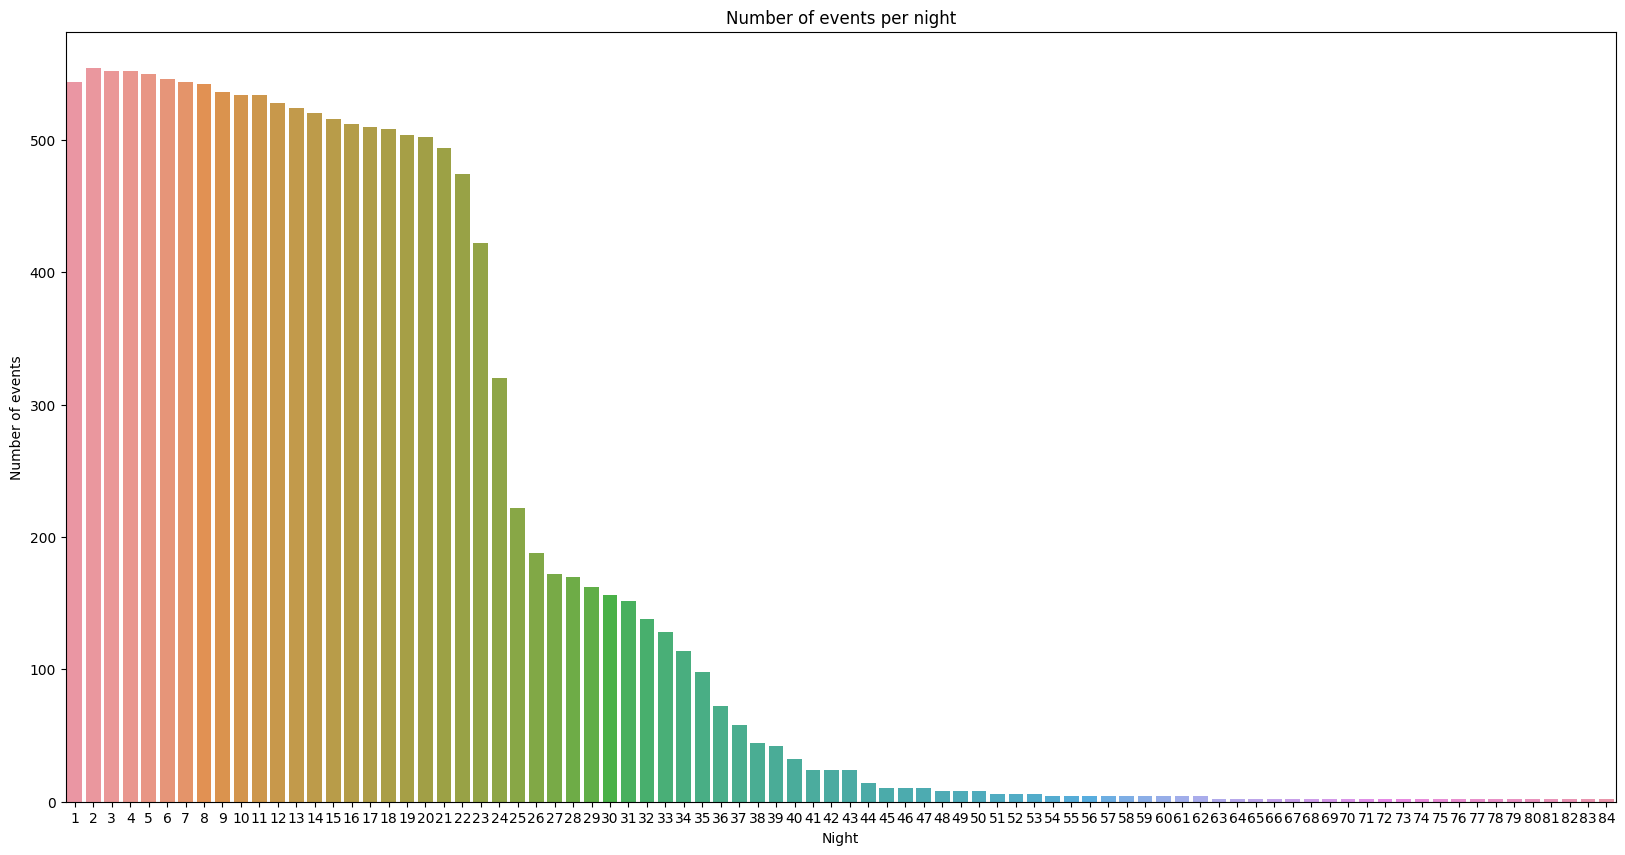

In [12]:
night_counts = df_events.groupby("night").size()
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=night_counts.reset_index(), x="night", y=0, ax=ax)
ax.set_title("Number of events per night")
ax.set_xlabel("Night")
ax.set_ylabel("Number of events")

**number of event by series**


c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

AttributeError: 'numpy.int64' object has no attribute 'startswith'

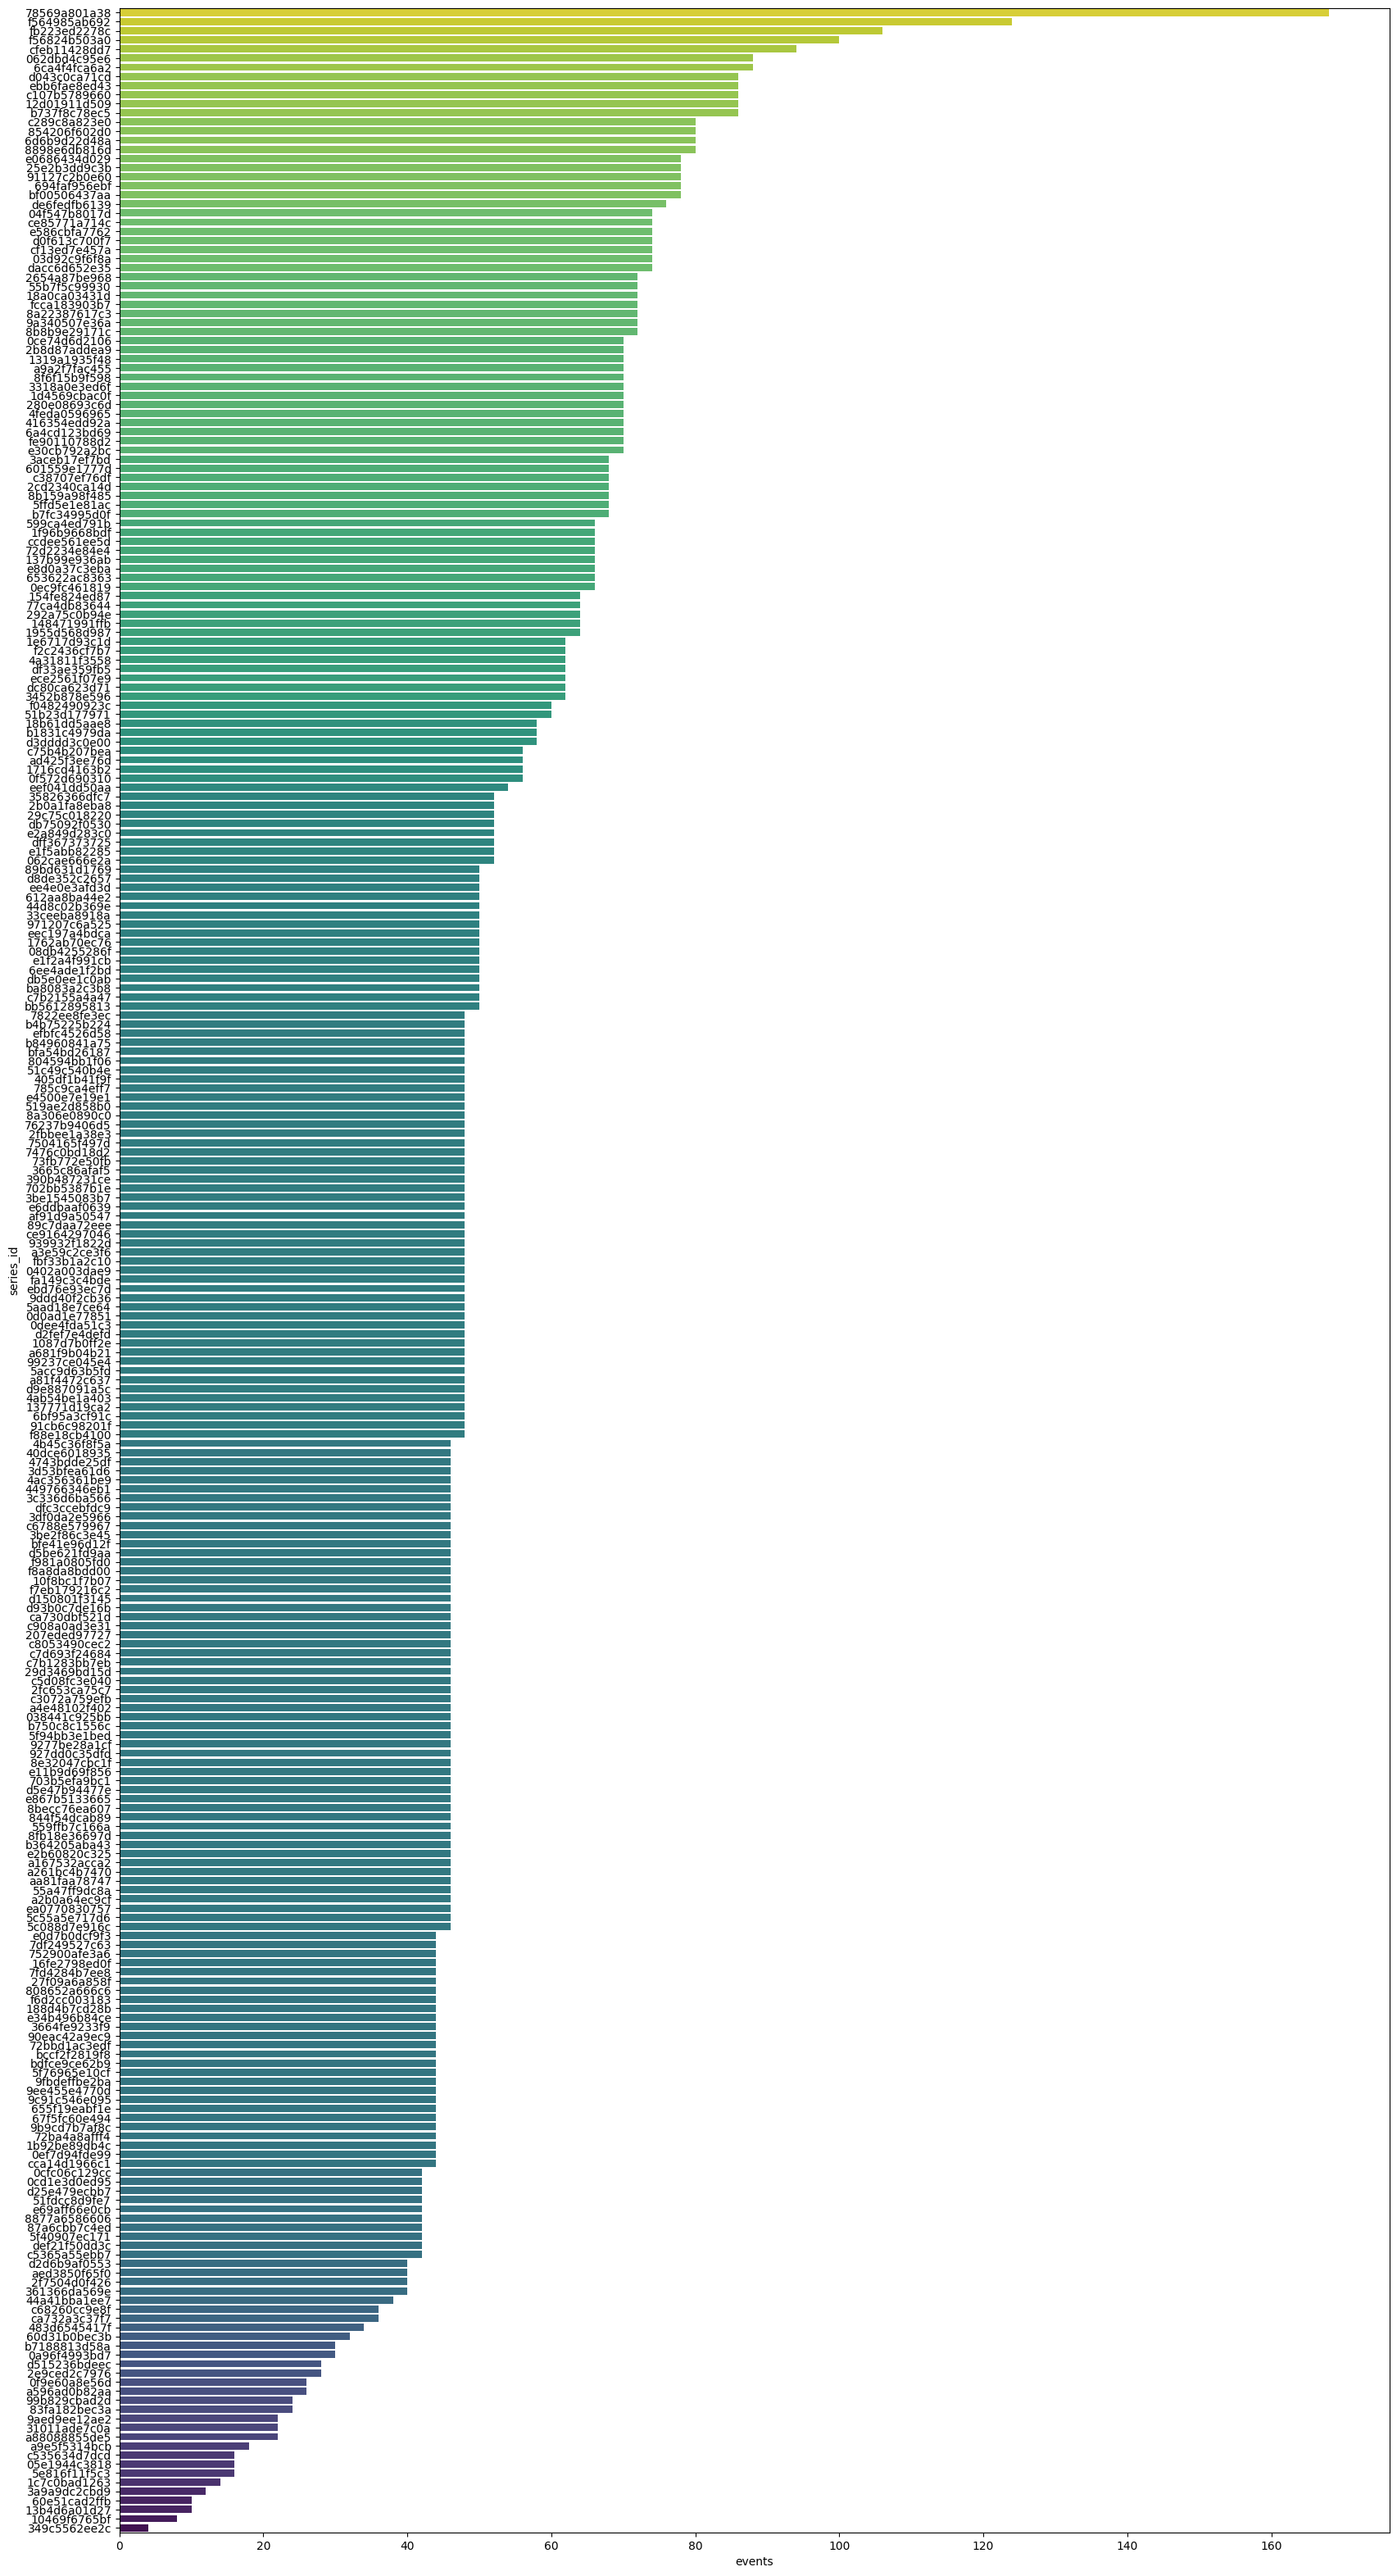

In [13]:
# Calculate number of nights by series and merge with event counts
df = (
    df_events.groupby("series_id")
    .agg(events=("series_id", "size"), nights=("night", "nunique"))
    .reset_index()
)

# Plot
plt.figure(figsize=(20, 40))
sns.barplot(
    data=df.sort_values(by="events", ascending=True),
    y="series_id",
    x="events",
    hue="nights",
    dodge=False,
    palette="viridis",
)

# Setting titles and labels
plt.title("Number of events per series")
plt.ylabel("series_id")
plt.xlabel("Number of events")
plt.legend(title="Number of Nights", loc="best")

plt.show()

**AngleZ**

A metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body.

In the range [-90,90]


In [14]:
df_signals["anglez"].describe()

statistic,value
str,f64
"""count""",1.2794634e8
"""null_count""",0.0
"""mean""",0.451053
"""std""",0.197344
"""min""",0.0
"""25%""",0.323006
"""50%""",0.446678
"""75%""",0.562779
"""max""",1.0


**enmo**

ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.

Positive values


In [15]:
df_signals["enmo"].describe()

statistic,value
str,f64
"""count""",1.2794634e8
"""null_count""",0.0
"""mean""",0.003613
"""std""",0.008906
"""min""",0.0
"""25%""",0.000114
"""50%""",0.001504
"""75%""",0.003822
"""max""",1.0


### Times Series Visualization


In [16]:
serie_id = df_signals.filter(df_signals["series_id"] == "038441c925bb")

**angle Z plot**


c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

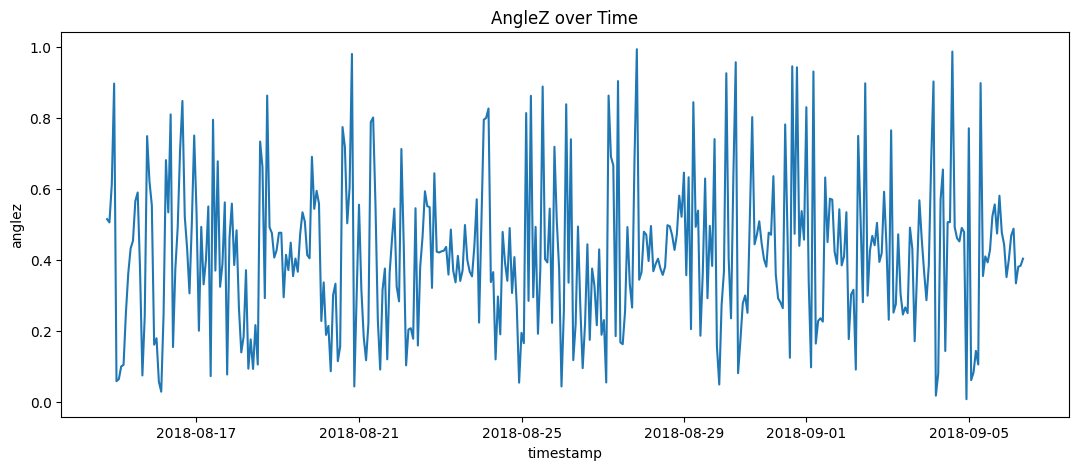

In [17]:
# Plotting anglez over time
_, ax = plt.subplots(figsize=(13, 5))
sns.lineplot(data=serie_id[::1000], x="timestamp", y="anglez")
plt.title("AngleZ over Time")
plt.show()

**enmo plot**


c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

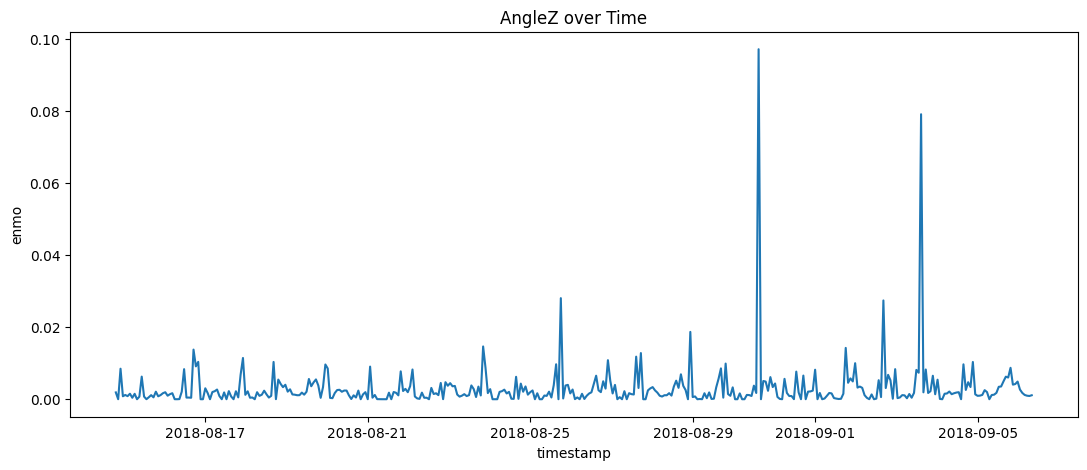

In [18]:
# Plotting enmo over time
_, ax = plt.subplots(figsize=(13, 5))
sns.lineplot(data=serie_id[::1000], x="timestamp", y="enmo")
plt.title("AngleZ over Time")
plt.show()

**angle Z Distribution**


c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


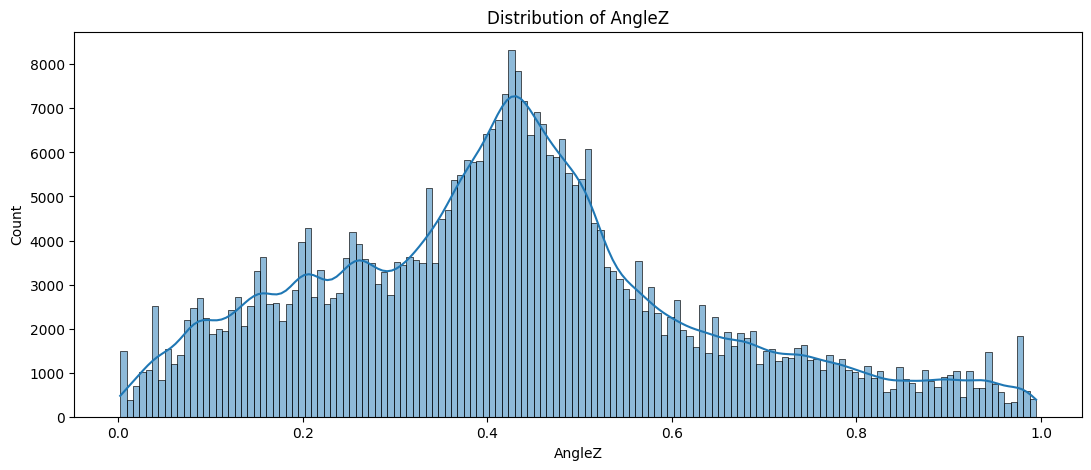

In [19]:
_, ax = plt.subplots(figsize=(13, 5))

sns.histplot(serie_id["anglez"], kde=True)
plt.title("Distribution of AngleZ")
ax.set_xlabel("AngleZ")
plt.show()

**enmo Distribution**


c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


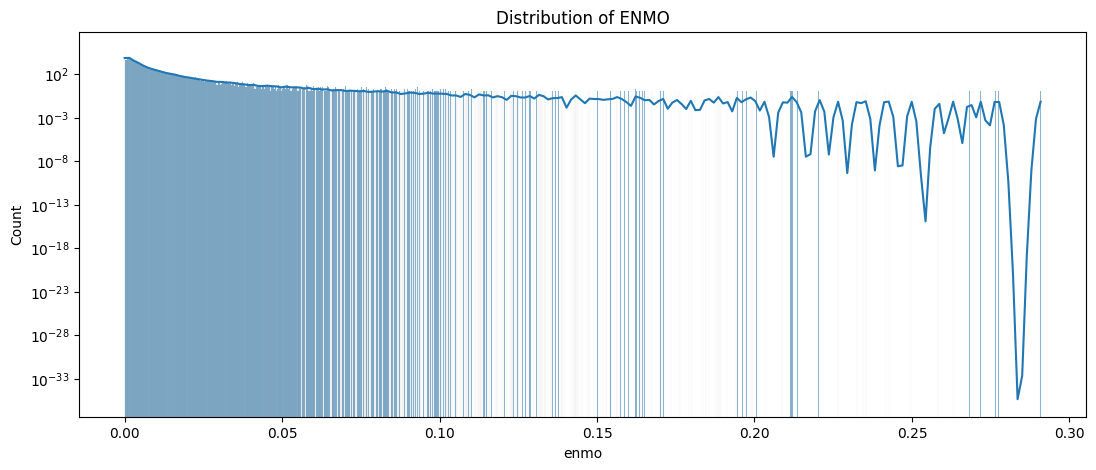

In [20]:
_, ax = plt.subplots(figsize=(13, 5))
sns.histplot(serie_id["enmo"], kde=True)
plt.yscale("log")
plt.title("Distribution of ENMO")
ax.set_xlabel("enmo")
plt.show()

### Duration of each Series


In [21]:
duration = (
    df_signals.group_by("series_id")
    .agg(
        duration=pl.col("timestamp").max() - pl.col("timestamp").min(),
        nb_rows=pl.col("timestamp").count(),
    )
    .with_columns(pl.col("duration").cast(pl.Duration(time_unit="ms")))
)
duration

series_id,duration,nb_rows
str,duration[ms],u32
"""d515236bdeec""",13d 15h 14m 55s,235620
"""10469f6765bf""",23d 7h 44m 55s,403020
"""dfc3ccebfdc9""",23d 9h 29m 55s,404280
"""ca730dbf521d""",23d 5h 44m 55s,401580
"""bdfce9ce62b9""",22d 5h 59m 55s,384480
"""3be1545083b7""",23d 16h 59m 55s,409680
"""0cfc06c129cc""",22d 6h 14m 55s,384660
"""694faf956ebf""",39d 7h 14m 55s,679140
"""c7b1283bb7eb""",23d 9h 29m 55s,404280


c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\magal\anaconda3\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

Text(0, 0.5, 'Percentage of Series')

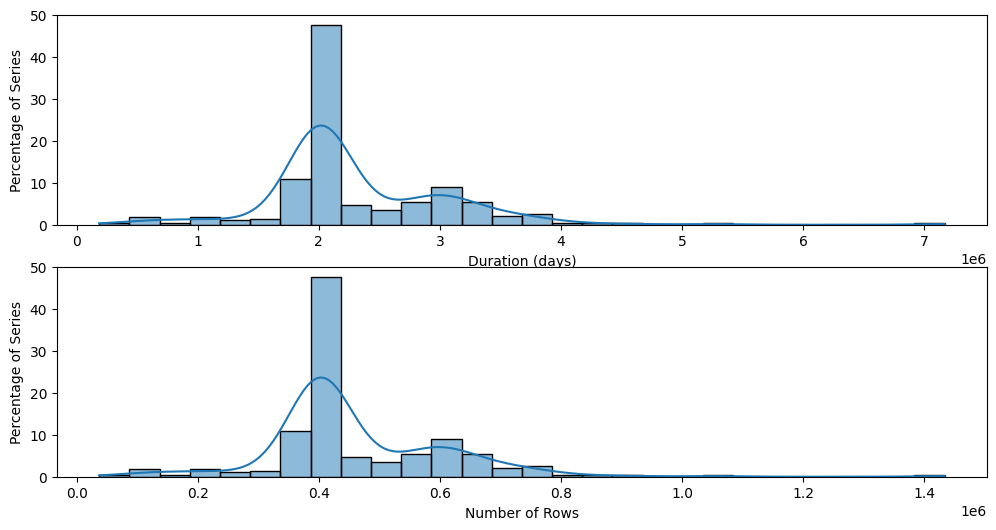

In [22]:
# Plot duration distribution
seconds = duration["duration"].dt.seconds()
nb_rows = duration["nb_rows"]
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

sns.histplot(data=seconds, kde=True, ax=ax1, stat="percent")
ax1.set_xlabel("Duration (days)")
ax1.set_ylabel("Percentage of Series")

sns.histplot(data=nb_rows, kde=True, ax=ax2, stat="percent")
ax2.set_xlabel("Number of Rows")
ax2.set_ylabel("Percentage of Series")

### Plot of the sleep of one series trough time


In [23]:
serie_signals = df_signals.filter(df_signals["series_id"] == "1b92be89db4c")
serie_events = df_events.query(f"series_id == '1b92be89db4c'")

In [24]:
def plot_sleep(
    serie_id: str, df_events: pd.DataFrame, ax: plt.Axes
) -> plt.Axes:
    """
    Plot sleep for a given serie_id

    Parameters
    ----------
    serie : str
        the serie_id to plot
    df_events : pd.DataFrame
        DataFrame containing the columns 'series_id', 'night', 'event', 'timestamp'
    """
    # Filter events for the given serie_id and sort by timestamp
    serie_events = df_events[df_events["series_id"] == serie_id].sort_values(
        by="timestamp", ascending=True
    )

    # Initialize containers for onsets and wakeups
    onset_times = []
    wakeup_times = []

    # Process events in order, pairing onsets with subsequent wakeups
    for idx, row in serie_events.iterrows():
        if row["event"] == "onset":
            onset_times.append(row["timestamp"])
        elif row["event"] == "wakeup" and onset_times:
            # Only plot if there is a previous 'onset' to pair with
            onset = onset_times.pop()
            wakeup = row["timestamp"]

            ax.plot(
                [onset, wakeup],
                [0.5, 0.5],
                color="blue",
                lw=10,
                solid_capstyle="butt",
            )

    ax.set_yticks([])
    ax.set_xlabel("Time")
    ax.set_title(f"Sleep Periods for {serie_id}")

    return ax

In [25]:
def plot_signals(
    serie: str, df_signals: pl.DataFrame, ax: plt.Axes
) -> plt.Axes:
    """
    Plot signals for a given serie_id

    Parameters
    ----------
    serie : str
        the serie_id to plot
    df_signals : pl.DataFrame
        DataFrame containing the columns 'series_id', 'timestamp', 'anglez', 'enmo'
    """
    # Filter signals for the given serie_id and sort by timestamp
    serie_signals = df_signals.filter(df_signals["series_id"] == serie).sort(
        "timestamp"
    )
    sns.lineplot(
        data=serie_signals[::100], x="timestamp", y="anglez", alpha=0.5
    )
    sns.lineplot(data=serie_signals[::100], x="timestamp", y="enmo", alpha=0.5)
    ax.set_title(f"Signals for {serie}")

    return ax

In [ ]:
_, ax = plt.subplots(figsize=(13, 5))
plot_sleep("1b92be89db4c", df_events, ax)
plot_signals("1b92be89db4c", df_signals, ax)

In [38]:
import plotly
import plotly.graph_objs as go


def plot_sleep_interactive(
    serie_id: str, df_events: pd.DataFrame, df_signals: pl.DataFrame
):
    """
    Plot sleep for a given serie_id

    Parameters
    ----------
    serie : str
        the serie_id to plot
    df_events : pd.DataFrame
        DataFrame containing the columns 'series_id', 'night', 'event', 'timestamp'
    df_signals : pl.DataFrame
        DataFrame containing the columns 'series_id', 'timestamp', 'anglez', 'enmo'
    """
    # Filter events for the given serie_id and sort by timestamp
    serie_events = df_events[df_events["series_id"] == serie_id].sort_values(
        by="timestamp", ascending=True
    )
    serie_signals = df_signals.filter(df_signals["series_id"] == serie_id).sort(
        "timestamp"
    )

    # _________________________________________________________________
    # Initialize layout
    # _________________________________________________________________

    traces = []
    layout = go.Layout(
        title=f"Sleep Periods for {serie_id}",
        xaxis=dict(
            title="Time",
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=True,
        ),
        yaxis=dict(
            title="",
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=False,
        ),
        showlegend=False,
        width=1920,
        height=1080,
    )

    # _________________________________________________________________
    # Plot signals
    # _________________________________________________________________

    trace_anglez = go.Scatter(
        x=serie_signals["timestamp"],
        y=serie_signals["anglez"],
        mode="lines",
        line=dict(
            color="green",
            width=1,
        ),
        hoverinfo="none",
    )
    traces.append(trace_anglez)

    trace_enmo = go.Scatter(
        x=serie_signals["timestamp"],
        y=serie_signals["enmo"],
        mode="lines",
        line=dict(
            color="red",
            width=1,
        ),
        hoverinfo="none",
    )
    traces.append(trace_enmo)

    # _________________________________________________________________
    # Plot sleep periods
    # _________________________________________________________________

    # Initialize containers for onsets and wakeups
    onset_times = []
    wakeup_times = []

    # Process events in order, pairing onsets with subsequent wakeups
    for idx, row in serie_events.iterrows():
        if row["event"] == "onset":
            onset_times.append(row["timestamp"])
        elif row["event"] == "wakeup" and onset_times:
            # Only plot if there is a previous 'onset' to pair with
            onset = onset_times.pop()
            wakeup = row["timestamp"]

            trace = go.Scatter(
                x=[onset, wakeup],
                y=[0.5,0.5],
                mode="lines",
                line=dict(
                    color="blue",
                    width=10,
                ),
                hoverinfo="none",
            )
            traces.append(trace)

    fig = go.Figure(data=traces, layout=layout)
    #plotly.offline.iplot(fig)
    return fig

In [ ]:
fig = plot_sleep_interactive("1b92be89db4c", df_events, df_signals)
fig.write_html("plot.html")


## Balanced/Unbalanced data

In [28]:
df_events.groupby("event").size()


event
onset     7254
wakeup    7254
dtype: int64

In [32]:
# check whether there is the same number of wakeup and onset events for each night
event_night = df_events.groupby(["night", "event"]).size().unstack()
for night in df_events["night"].unique():
    # count the number of wakeup and onset events for the given night
      nb_wakeup = event_night.loc[night, "wakeup"]
      nb_onset = event_night.loc[night, "onset"]
      if nb_wakeup != nb_onset:
          print(f"Night {night}: {nb_wakeup} wakeups and {nb_onset} onsets")

In [37]:
# check whether there are the same number of wakeup and onset in each series
event_series = df_events.groupby(["series_id", "event"]).size().unstack()
for serie in df_events["series_id"].unique():
    # count the number of wakeup and onset events for the given night
      nb_wakeup = event_series.loc[serie, "wakeup"]
      nb_onset = event_series.loc[serie, "onset"]
      if nb_wakeup != nb_onset:
          print(f"Serie {serie}: {nb_wakeup} wakeups and {nb_onset} onsets")